<h1>DECibits</h1>
Mobile service churn prediction

### Import Modules and Collect Dataset

In [16]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    ShuffleSplit,
    KFold
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    VotingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import metrics, feature_selection
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    recall_score,
    confusion_matrix,
    precision_score,
    f1_score,
    classification_report,
    fbeta_score,
    precision_recall_curve,
    auc,
    roc_auc_score,
    make_scorer,
    log_loss,
    average_precision_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor


path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [17]:
data = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Analyze the dataset

In [18]:
data.info()

print("\nDateset Shape\t: ",data.shape, "\n")

print("Null Values\t: ", data.isnull().any().any(),"\n")

for col in data.columns:
    if data[col].dtype == 'object':
        if (data[col].astype(str).str.strip() == '').any():
            print(f"Space Values\t: '{col}'")
print("")

for col in data.columns:
    if (data[col] == 0).any():
        print(f"Zero Values\t: '{col}'")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Remove the customerID and fill the misssing values

In [19]:
data = data.drop(["customerID"], axis = 1)

data.drop(labels=data[data["tenure"] == 0].index, axis = 0, inplace = True)

data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors = "coerce")
data.fillna(data["TotalCharges"].mean())

data.SeniorCitizen = data.SeniorCitizen.map({0: "No", 1: "Yes"})

data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [20]:
data.info()

print("\nDateset Shape\t: ",data.shape, "\n")

print("Null Values\t: ", data.isnull().any().any(),"\n")

for col in data.columns:
    if data[col].dtype == 'object':
        if (data[col].astype(str).str.strip() == '').any():
            print(f"Space Values\t: '{col}'")
print("\n")

for col in data.columns:
    if (data[col] == 0).any():
        print(f"Zero Values\t: '{col}'")

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   object 
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

### Encode categorical variables

In [21]:
binary_cols = [col for col in data.columns if data[col].nunique() == 2]
multi_cols = [col for col in data.columns if data[col].nunique() > 2 and data[col].dtype == 'object']

le = LabelEncoder()
for col in binary_cols:
    data[col] = le.fit_transform(data[col])

data = pd.get_dummies(data, columns=multi_cols)

### Split Data and Scale Features

In [22]:
# Split Data
X = data.drop("Churn", axis=1)
y = data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train and Evaluate Models

In [23]:
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "ExtraTrees": ExtraTreesClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 0
    results[name] = {
        "accuracy": model.score(X_test, y_test),
        "roc_auc": auc,
        "report": classification_report(y_test, y_pred, output_dict=True)
    }

In [24]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print("Classification Report:")
    report_df = pd.DataFrame(metrics['report']).transpose()
    display(report_df)
    print("-" * 50)

Model: LogisticRegression
Accuracy: 0.8038
ROC AUC: 0.8356
Classification Report:


,precision,recall,f1-score,support
0,0.852093,0.886738,0.869070,1033.000000
1,0.647590,0.574866,0.609065,374.000000
accuracy,0.803838,0.803838,0.803838,0.803838
macro avg,0.749842,0.730802,0.739068,1407.000000
weighted avg,0.797733,0.803838,0.799957,1407.000000


--------------------------------------------------
Model: RandomForest
Accuracy: 0.7861
ROC AUC: 0.8104
Classification Report:


,precision,recall,f1-score,support
0,0.829137,0.892546,0.859674,1033.00000
1,0.623729,0.491979,0.550075,374.00000
accuracy,0.786070,0.786070,0.786070,0.78607
macro avg,0.726433,0.692262,0.704874,1407.00000
weighted avg,0.774536,0.786070,0.777378,1407.00000


--------------------------------------------------
Model: GradientBoosting
Accuracy: 0.7960
ROC AUC: 0.8386
Classification Report:


,precision,recall,f1-score,support
0,0.839709,0.892546,0.865321,1033.00000
1,0.640777,0.529412,0.579795,374.00000
accuracy,0.796020,0.796020,0.796020,0.79602
macro avg,0.740243,0.710979,0.722558,1407.00000
weighted avg,0.786830,0.796020,0.789425,1407.00000


--------------------------------------------------
Model: SVM
Accuracy: 0.7882
ROC AUC: 0.7890
Classification Report:


,precision,recall,f1-score,support
0,0.833787,0.888674,0.860356,1033.000000
1,0.624183,0.510695,0.561765,374.000000
accuracy,0.788202,0.788202,0.788202,0.788202
macro avg,0.728985,0.699684,0.711060,1407.000000
weighted avg,0.778072,0.788202,0.780986,1407.000000


--------------------------------------------------
Model: KNN
Accuracy: 0.7434
ROC AUC: 0.7696
Classification Report:


,precision,recall,f1-score,support
0,0.826848,0.822846,0.824842,1033.000000
1,0.517150,0.524064,0.520584,374.000000
accuracy,0.743426,0.743426,0.743426,0.743426
macro avg,0.671999,0.673455,0.672713,1407.000000
weighted avg,0.744526,0.743426,0.743966,1407.000000


--------------------------------------------------
Model: NaiveBayes
Accuracy: 0.6816
ROC AUC: 0.8072
Classification Report:


,precision,recall,f1-score,support
0,0.914894,0.624395,0.742232,1033.000000
1,0.447293,0.839572,0.583643,374.000000
accuracy,0.681592,0.681592,0.681592,0.681592
macro avg,0.681094,0.731984,0.662938,1407.000000
weighted avg,0.790599,0.681592,0.700077,1407.000000


--------------------------------------------------
Model: DecisionTree
Accuracy: 0.7342
ROC AUC: 0.6649
Classification Report:


,precision,recall,f1-score,support
0,0.822723,0.813166,0.817916,1033.000000
1,0.500000,0.516043,0.507895,374.000000
accuracy,0.734186,0.734186,0.734186,0.734186
macro avg,0.661361,0.664604,0.662905,1407.000000
weighted avg,0.736939,0.734186,0.735508,1407.000000


--------------------------------------------------
Model: AdaBoost
Accuracy: 0.7903
ROC AUC: 0.8356
Classification Report:


,precision,recall,f1-score,support
0,0.837294,0.886738,0.861307,1033.000000
1,0.626198,0.524064,0.570597,374.000000
accuracy,0.790334,0.790334,0.790334,0.790334
macro avg,0.731746,0.705401,0.715952,1407.000000
weighted avg,0.781182,0.790334,0.784032,1407.000000


--------------------------------------------------
Model: ExtraTrees
Accuracy: 0.7704
ROC AUC: 0.7862
Classification Report:


,precision,recall,f1-score,support
0,0.826287,0.870281,0.847713,1033.000000
1,0.579937,0.494652,0.533911,374.000000
accuracy,0.770434,0.770434,0.770434,0.770434
macro avg,0.703112,0.682467,0.690812,1407.000000
weighted avg,0.760804,0.770434,0.764300,1407.000000


--------------------------------------------------


In [25]:
model_names = list(results.keys())
accuracy_scores = [results[name]['accuracy'] for name in model_names]
roc_auc_scores = [results[name]['roc_auc'] for name in model_names]

fig = make_subplots(rows=1, cols=2, subplot_titles=('Model Accuracy', 'Model ROC AUC'))

fig.add_trace(go.Bar(x=model_names, y=accuracy_scores, name='Accuracy'), row=1, col=1)
fig.add_trace(go.Bar(x=model_names, y=roc_auc_scores, name='ROC AUC'), row=1, col=2)

fig.update_layout(title_text="Model Performance Comparison", showlegend=False)
fig.show()

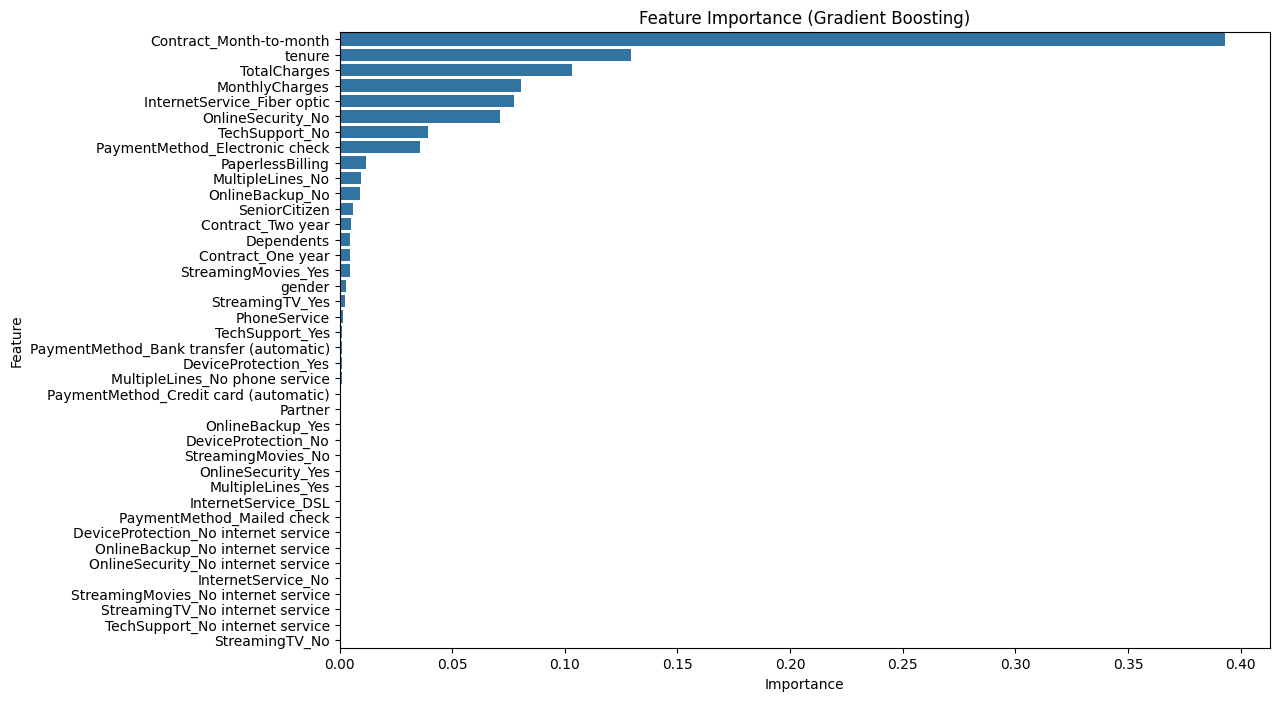

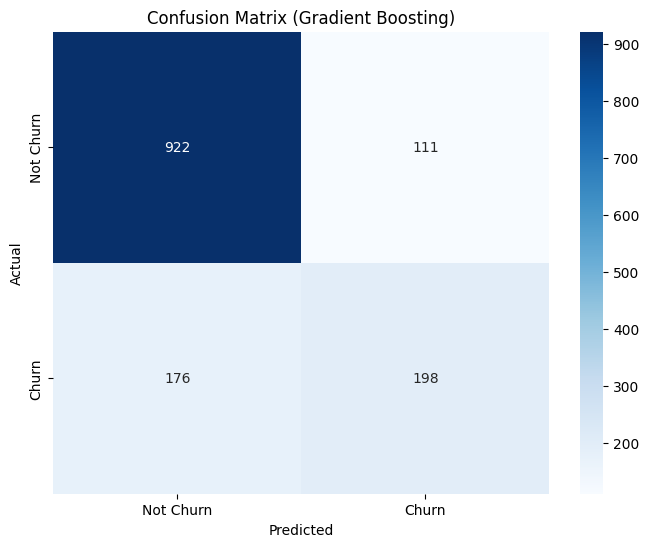

In [26]:
# Visualize Feature Importance for the Gradient Boosting
best_model = models["GradientBoosting"]
feature_importance = best_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Gradient Boosting)')
plt.show()

# Visualize Confusion Matrix for the Gradient Boosting
cm = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Gradient Boosting)')
plt.show()

In [27]:
best_model = max(results, key=lambda k: results[k]['roc_auc'])
print(f"Best Model: {best_model}")
print(f"Accuracy: {results[best_model]['accuracy']:.4f}")
print(f"ROC AUC: {results[best_model]['roc_auc']:.4f}")
print("Classification Report:")
print(pd.DataFrame(results[best_model]["report"]).T)

Best Model: GradientBoosting
Accuracy: 0.7960
ROC AUC: 0.8386
Classification Report:
              precision    recall  f1-score     support
0              0.839709  0.892546  0.865321  1033.00000
1              0.640777  0.529412  0.579795   374.00000
accuracy       0.796020  0.796020  0.796020     0.79602
macro avg      0.740243  0.710979  0.722558  1407.00000
weighted avg   0.786830  0.796020  0.789425  1407.00000


### Dump Gradient-Boost, Columns and Scallers

In [28]:
import joblib

# Dump Gradient Boosting model
joblib.dump(models["GradientBoosting"], 'gradient_boosting_model.pkl')

# Dump the scaler
joblib.dump(scaler, 'scaler.pkl')

# Dump the list of columns
joblib.dump(X.columns.tolist(), 'columns.pkl')

print("Gradient Boosting model, scaler, and columns have been dumped.")

Gradient Boosting model, scaler, and columns have been dumped.


In [29]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import (
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
)


path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn
